## Pre-processing data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pandas as pd
from tqdm.notebook import tqdm

plt.rcParams.update({'font.size': 14})
sns.set_style('whitegrid')

In [ ]:
%%bash
mkdir IMDB
wget https://huggingface.co/datasets/stanfordnlp/imdb/resolve/main/plain_text/train-00000-of-00001.parquet?download=true -O IMDB/train.parquet
wget https://huggingface.co/datasets/stanfordnlp/imdb/resolve/main/plain_text/test-00000-of-00001.parquet?download=true -O IMDB/valid.parquet

In [13]:
train = pd.read_parquet('IMDB/train.parquet')
train.to_csv('IMDB/train.csv', index=None)
valid = pd.read_parquet('IMDB/valid.parquet')
valid.to_csv('IMDB/test.csv', index=None)

In [14]:
train_set = pd.read_csv('IMDB/train.csv').rename(columns={'text': 'raw_text'})
test_set = pd.read_csv('IMDB/test.csv').rename(columns={'text': 'raw_text'})

train_set.shape, test_set.shape

((25000, 2), (25000, 2))

In [15]:
train_set.head()

,raw_text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0


In [16]:
train_set['label'].value_counts()

0    12500
1    12500
Name: label, dtype: int64

In [17]:
test_set['label'].value_counts()

0    12500
1    12500
Name: label, dtype: int64

In [18]:
train_set.loc[101]['raw_text']

'Assuming this won\'t end up a straight-to-video release, I would have to say void this title at all costs. Unless you\'re bored of good, well-executed movies, that is. I saw this last night at AFI Dallas, and I left with 20 minutes remaining, simply because I didn\'t care anymore (about the plot, not about insulting the director...that is awkward). When you can spot a goof only 5 minutes into the movie (a shot out, shattered window before any shots are fired...and then the window breaks with the first shot), things are going to bad. Let\'s just say this is only an indicator of things to come...unfortunately.<br /><br />I\'ll spare you all the details, but this is sub-par in every manner, even the half-assed acting by Michael Madsen is disappointing when you\'re expecting half-assed acting from him. And the rape scene...Christ! "Shut up and take it" should never be used in a rape scene. EVER.<br /><br />3/10'

In [19]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [20]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/isadrtdinov/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [21]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to
[nltk_data]     /home/isadrtdinov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/isadrtdinov/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/isadrtdinov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
list(stop_words)[:20]

["didn't",
 'couldn',
 'haven',
 'out',
 'myself',
 'about',
 'ourselves',
 "you've",
 'so',
 'yours',
 'don',
 'all',
 'an',
 'against',
 'ain',
 'any',
 "she's",
 'as',
 "that'll",
 'of']

In [23]:
def preprocess(text):
    text = list(filter(str.isalpha, word_tokenize(text.lower())))
    text = list(lemmatizer.lemmatize(word) for word in text)
    text = list(word for word in text if word not in stop_words)
    return ' '.join(text)

In [24]:
train_set['text'] = train_set.apply(lambda row: preprocess(row.raw_text), axis=1)
test_set['text'] = test_set.apply(lambda row: preprocess(row.raw_text), axis=1)

In [26]:
train_set.to_csv('IMDB/processed_train.csv', index=None)
test_set.to_csv('IMDB/processed_test.csv', index=None)

In [27]:
train_set.loc[101]['text']

'assuming wo end release would say void title cost unless bored good movie saw last night afi dallas left minute remaining simply care anymore plot insulting director awkward spot goof minute movie shot shattered window shot fired window break first shot thing going bad let say indicator thing come br br spare detail every manner even acting michael madsen disappointing expecting acting rape scene christ shut take never used rape scene br br'

In [2]:
train_set = pd.read_csv('IMDB/processed_train.csv')
test_set = pd.read_csv('IMDB/processed_test.csv')

## Baseline

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [4]:
tf_idf = TfidfVectorizer().fit(train_set['text'])
train_tf_idf = tf_idf.transform(train_set['text'])
test_tf_idf = tf_idf.transform(test_set['text'])

In [5]:
log_regr = LogisticRegression(n_jobs=-1).fit(train_tf_idf, train_set['label'])

In [6]:
print(f'Train acc: {accuracy_score(train_set["label"], log_regr.predict(train_tf_idf)):.4f}')
print(f'Test acc: {accuracy_score(test_set["label"], log_regr.predict(test_tf_idf)):.4f}')

Train acc: 0.9328
Test acc: 0.8784


## Tokenizing data

In [64]:
from collections import Counter
from torchtext.vocab import Vocab

counter = Counter(token for sent in train_set['text'] for token in sent.split(' '))
vocab = Vocab(counter, specials=['<pad>', '<cls>', '<unk>'], min_freq=5)
len(vocab)

24858

In [69]:
CLS_ID = vocab['<cls>']

train_tokens = []
for text in tqdm(train_set['text']):
    tokens = [CLS_ID] + [vocab[word] for word in text.split(' ')]
    train_tokens += [tokens]

test_tokens = []
for text in tqdm(test_set['text']):
    tokens = [CLS_ID] + [vocab[word] for word in text.split(' ')]
    test_tokens += [tokens]

  0%|          | 0/25000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

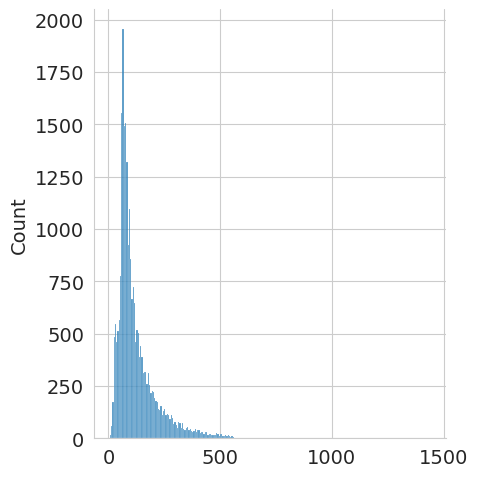

In [70]:
lengths = np.array([len(tokens) for tokens in train_tokens])
sns.displot(lengths)
plt.show()

In [71]:
max_length = 256

tokenized_train = torch.full((len(train_tokens), max_length), vocab['<pad>'], dtype=torch.int32)
for i, tokens in enumerate(train_tokens):
    length = min(max_length, len(tokens))
    tokenized_train[i, :length] = torch.tensor(tokens[:length])

tokenized_test = torch.full((len(test_tokens), max_length), vocab['<pad>'], dtype=torch.int32)
for i, tokens in enumerate(test_tokens):
    length = min(max_length, len(tokens))
    tokenized_test[i, :length] = torch.tensor(tokens[:length])

In [72]:
tokenized_train

tensor([[    1,  1381,   262,  ...,     0,     0,     0],
        [    1,  1758,  3799,  ...,     0,     0,     0],
        [    1,   637,   156,  ...,     0,     0,     0],
        ...,
        [    1,     6,   472,  ...,     0,     0,     0],
        [    1,   749,  2972,  ...,  2010,  2561, 14909],
        [    1,    14,  1471,  ...,     0,     0,     0]], dtype=torch.int32)

In [73]:
targets_train = torch.tensor(train_set['label'], dtype=torch.int32)
targets_test = torch.tensor(test_set['label'], dtype=torch.int32)

In [74]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(tokenized_train, targets_train)
test_dataset = TensorDataset(tokenized_test, targets_test)

batch_size = 128

train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False, num_workers=0, pin_memory=True)

## Transformer architecture

In [75]:
import math
from torch import nn

class PositionalEncoder(nn.Module):
    # Adapted from: https://pytorch.org/tutorials/beginner/transformer_tutorial.html

    def __init__(self, max_length, embed_dim, dropout):
        super().__init__()
        self.pos_features = torch.zeros(max_length, embed_dim)

        positions = torch.arange(0, max_length, dtype=torch.float).unsqueeze(1)
        freqs = torch.exp(torch.arange(0, embed_dim, 2, dtype=torch.float) * \
                          (-math.log(10000) / embed_dim)).unsqueeze(0)

        arguments = positions * freqs
        self.pos_features[:, 0::2] = torch.sin(arguments)
        self.pos_features[:, 1::2] = torch.cos(arguments)
        self.pos_features = self.pos_features.unsqueeze(0)
        self.pos_features = nn.Parameter(self.pos_features, requires_grad=False)
        # pos_features: (1, max_length, embed_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, inputs):
        outputs = inputs + self.pos_features[:, :inputs.shape[1]]
        return self.dropout(outputs)

![](https://jalammar.github.io/images/t/self-attention-matrix-calculation-2.png)
![](https://sebastianraschka.com/images/blog/2023/self-attention-from-scratch/summary.png)

In [87]:
class Attention(nn.Module):
    # Single-head attention
    def __init__(self, embed_dim, num_heads, dropout):
        super().__init__()
        attention_dim = embed_dim // num_heads

        self.WQ = nn.Linear(embed_dim, attention_dim, bias=False)
        self.WK = nn.Linear(embed_dim, attention_dim, bias=False)
        self.WV = nn.Linear(embed_dim, attention_dim, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value, mask=None):
        # query, key, value: (batch_size, length, embed_dim)
        # mask: (batch_size, length, length)

        Q = self.WQ(query)
        K = self.WK(key)
        V = self.WV(value)
        # Q, K, V: (batch_size, length, attention_dim)

        norm_factor = math.sqrt(Q.shape[-1])
        dot_products = torch.bmm(Q, K.transpose(1, 2)) / norm_factor
        # dot_products: (batch_size, length, length)

        if mask is not None:
            dot_products = dot_products.masked_fill(mask, -math.inf)

        attention_score = nn.functional.softmax(dot_products, dim=-1)
        attention = torch.bmm(self.dropout(attention_score), V)
        # attention_score: (batch_size, length, length)
        # attention: (batch_size, length, attention_dim)

        return attention, attention_score


class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout):
        super(MultiHeadAttention, self).__init__()

        assert embed_dim % num_heads == 0
        self.attention_heads = nn.ModuleList([Attention(embed_dim, num_heads, dropout)
                                              for _ in range(num_heads)])

        self.linear = nn.Linear(embed_dim, embed_dim, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value, mask=None):
        # query, key, value: (batch_size, length, embed_dim)
        # mask: (batch_size, length, length)
        attentions, attention_scores = [], []

        for head in self.attention_heads:
            attention, attention_score = head(query, key, value, mask)
            attentions += [attention]
            attention_scores += [attention_score]

        attentions = torch.cat(attentions, dim=-1)
        attention_scores = torch.stack(attention_scores, dim=-1)
        # attentions: (batch_size, length, embed_dim)
        # attention_scores: (batch_size, length, length, num_heads)

        outputs = self.linear(attentions)
        outputs = self.dropout(outputs)
        # outputs: (batch_size, length, embed_dim)

        return outputs, attention_scores

In [88]:
def create_padding_mask(tokens, pad_idx=vocab['<pad>']):
    # tokens: (batch_size, length)
    length = tokens.shape[-1]
    padding_mask = (tokens == pad_idx)
    padding_mask = padding_mask.unsqueeze(1).repeat(1, length, 1)
    # padding_mask: (batch_size, length, length)

    return padding_mask

In [89]:
class TransformerLayer(nn.Module):
    def __init__(self, embed_dim, fc_dim, num_heads, dropout):
        super().__init__()
        self.self_attention = MultiHeadAttention(embed_dim, num_heads, dropout)
        self.feedforward = nn.Sequential(
            nn.Linear(embed_dim, fc_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(fc_dim, embed_dim),
            nn.Dropout(dropout)
        )
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, inputs, mask):
        attention, attention_score = self.self_attention(
            query=inputs,
            key=inputs, 
            value=inputs,
            mask=mask
        )
        outputs = inputs + attention
        outputs = self.norm1(outputs)
        outputs = outputs + self.feedforward(outputs)
        outputs = self.norm2(outputs)
        return outputs, attention_score


class Transformer(nn.Module):
    def __init__(self, vocab_size, max_length, num_classes,
                 embed_dim, fc_dim, num_heads, num_layers, dropout):
        super().__init__()
        self.embed_dim = embed_dim
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.pos_encoder = PositionalEncoder(max_length, embed_dim, dropout)
        self.layers = nn.ModuleList([TransformerLayer(embed_dim, fc_dim, num_heads, dropout) \
                                     for _ in range(num_layers)])
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, tokens):
        # source: (batch_size, length)
        embeds = self.embedding(tokens) * math.sqrt(self.embed_dim)
        outputs = self.pos_encoder(embeds)
        # outputs: (batch_size, length, embed_dim)

        padding_mask = create_padding_mask(tokens)
        attention_scores = []
        for layer in self.layers:
            outputs, attention_score = layer(outputs, padding_mask)
            attention_scores += [attention_score]
        attention_scores = torch.stack(attention_scores, dim=-1)
        # outputs: (batch_size, length, embed_dim)
        # attentions_scores: (batch_size, length, embed_dim, num_heads, num_layers)

        logits = self.classifier(outputs[:, 0])
        # logits: (batch_size, num_classes)

        return logits, attention_scores

In [90]:
from IPython.display import clear_output

def plot_losses(train_losses, test_losses, train_accuracies, test_accuracies):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='test')
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

In [114]:
warmup_epochs, num_epochs = 5, 30
def warmup_cosine_scheduler(epoch):
    if (epoch + 1) <= warmup_epochs:
        return (epoch + 1) / warmup_epochs
    else:
        coef = (epoch - warmup_epochs) / (num_epochs - warmup_epochs)
        return (1 + np.cos(coef * np.pi)) / 2

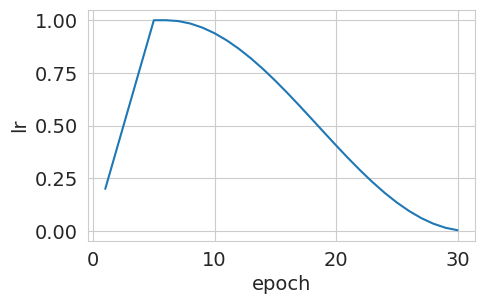

In [115]:
scheduler = torch.optim.lr_scheduler.LambdaLR(
    torch.optim.SGD([torch.tensor([0])], lr=1),
    warmup_cosine_scheduler
)

lrs = []
for i in range(num_epochs):
    lrs.append(scheduler.get_last_lr())
    scheduler.step()

plt.figure(figsize=(5, 3))
plt.plot(range(1, num_epochs + 1), lrs)
plt.xlabel('epoch')
plt.ylabel('lr')
plt.show()

In [116]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = Transformer(
    vocab_size=len(vocab),
    max_length=max_length,
    num_classes=1,
    embed_dim=128,
    fc_dim=256,
    num_heads=2,
    num_layers=3,
    dropout=0.1
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, warmup_cosine_scheduler)
criterion = nn.BCEWithLogitsLoss()

In [117]:
sum(param.numel() for param in model.parameters())

3610625

## Training

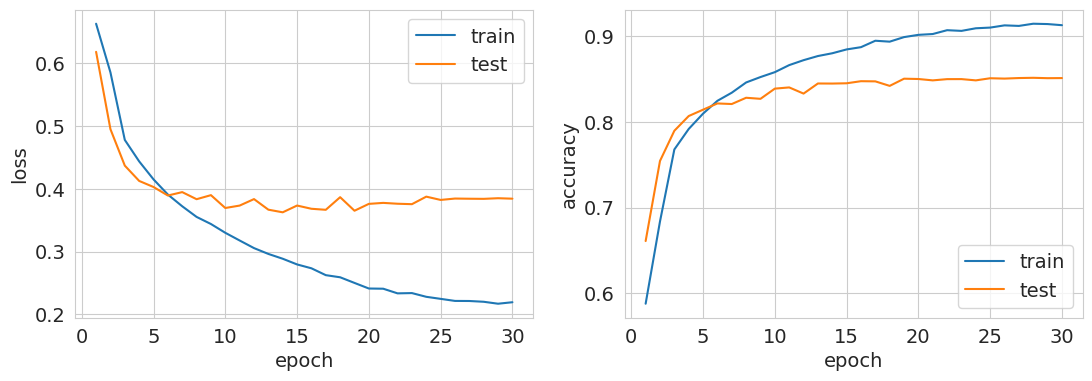

Best test accuracy: 0.85164


In [118]:
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss, running_accuracy = 0.0, 0.0
    for tokens, labels in tqdm(train_loader, desc=f'Training {epoch}/{num_epochs}'):
        optimizer.zero_grad()
        tokens = tokens.to(device)
        labels = labels.to(device)
        
        logits = model(tokens)[0].squeeze(1)
        loss = criterion(logits, labels.to(torch.float))
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * tokens.shape[0]
        running_accuracy += ((logits > 0).to(torch.int) == labels).sum().item()

    train_losses += [running_loss / len(train_loader.dataset)]
    train_accuracies += [running_accuracy / len(train_loader.dataset)]
    scheduler.step()

    model.eval()
    running_loss, running_accuracy = 0.0, 0.0
    for tokens, labels in tqdm(test_loader, desc=f'Testing {epoch}/{num_epochs}'):
        tokens = tokens.to(device)
        labels = labels.to(device)
        
        with torch.no_grad():
            logits = model(tokens)[0].squeeze(1)
            loss = criterion(logits, labels.to(torch.float))

        running_loss += loss.item() * tokens.shape[0]
        running_accuracy += ((logits > 0).to(torch.int) == labels).sum().item()
    
    test_losses += [running_loss / len(test_loader.dataset)]
    test_accuracies += [running_accuracy / len(test_loader.dataset)]
    plot_losses(train_losses, test_losses, train_accuracies, test_accuracies)

print(f'Best test accuracy: {max(test_accuracies)}')

## Visualizing attention scores

In [119]:
for tokens, labels in train_loader:
    tokens = tokens.to(device)
    labels = labels.to(device)
    break

In [120]:
tokens = tokens[:1]
tokens

tensor([[    1,   192,  1584,   187, 11431,    13,   402,  2423,  3011,  1463,
           191,   667,    25,  2971,   712,  1418,   860,     4,    29,   146,
           173,    37,   402,    59,  1189,    30,  2402,  2114,  2015,  2896,
            61,  2882,  7121,     2,   835,   376,   798,  6430,     5,   697,
          5069,    30,  1039,   831,  2579,  1339,  3469,    55,  4485,  2890,
            53,     4,   128,    46,     6,    17,   199,     4,    33,    51,
             2,     6,     8, 11764,  3943,    36,   379,    46,  8784,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

In [121]:
(tokens != 0).sum()

tensor(69, device='cuda:0')

In [122]:
tokens = tokens[:, :(tokens != 0).sum().item()]

In [123]:
with torch.no_grad():
    logits, scores = model(tokens)

In [124]:
scores.shape

torch.Size([1, 69, 69, 2, 3])

In [125]:
scores[0, ..., 0, 0].sum(-1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000], device='cuda:0')

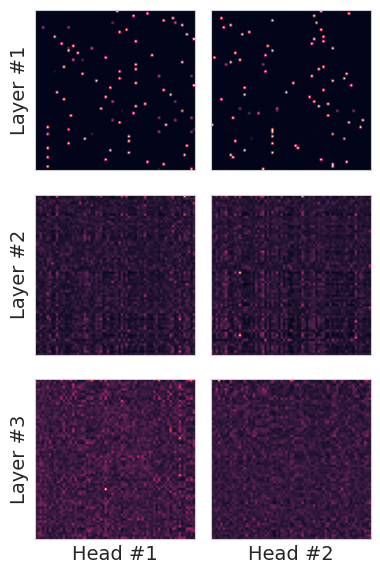

In [127]:
fig, axs = plt.subplots(3, 2, figsize=(4, 6))

for i in range(2):
    axs[-1, i].set_xlabel(f'Head #{i + 1}')
    for j in range(3):
        axs[j, 0].set_ylabel(f'Layer #{j + 1}')
        axs[j, i].imshow(scores[0, ..., i, j].cpu().numpy())
        axs[j, i].grid()
        axs[j, i].xaxis.set_ticks([])
        axs[j, i].yaxis.set_ticks([])

plt.tight_layout()
plt.show()

In [128]:
words = [vocab.itos[token] for token in tokens.squeeze().cpu().numpy()]

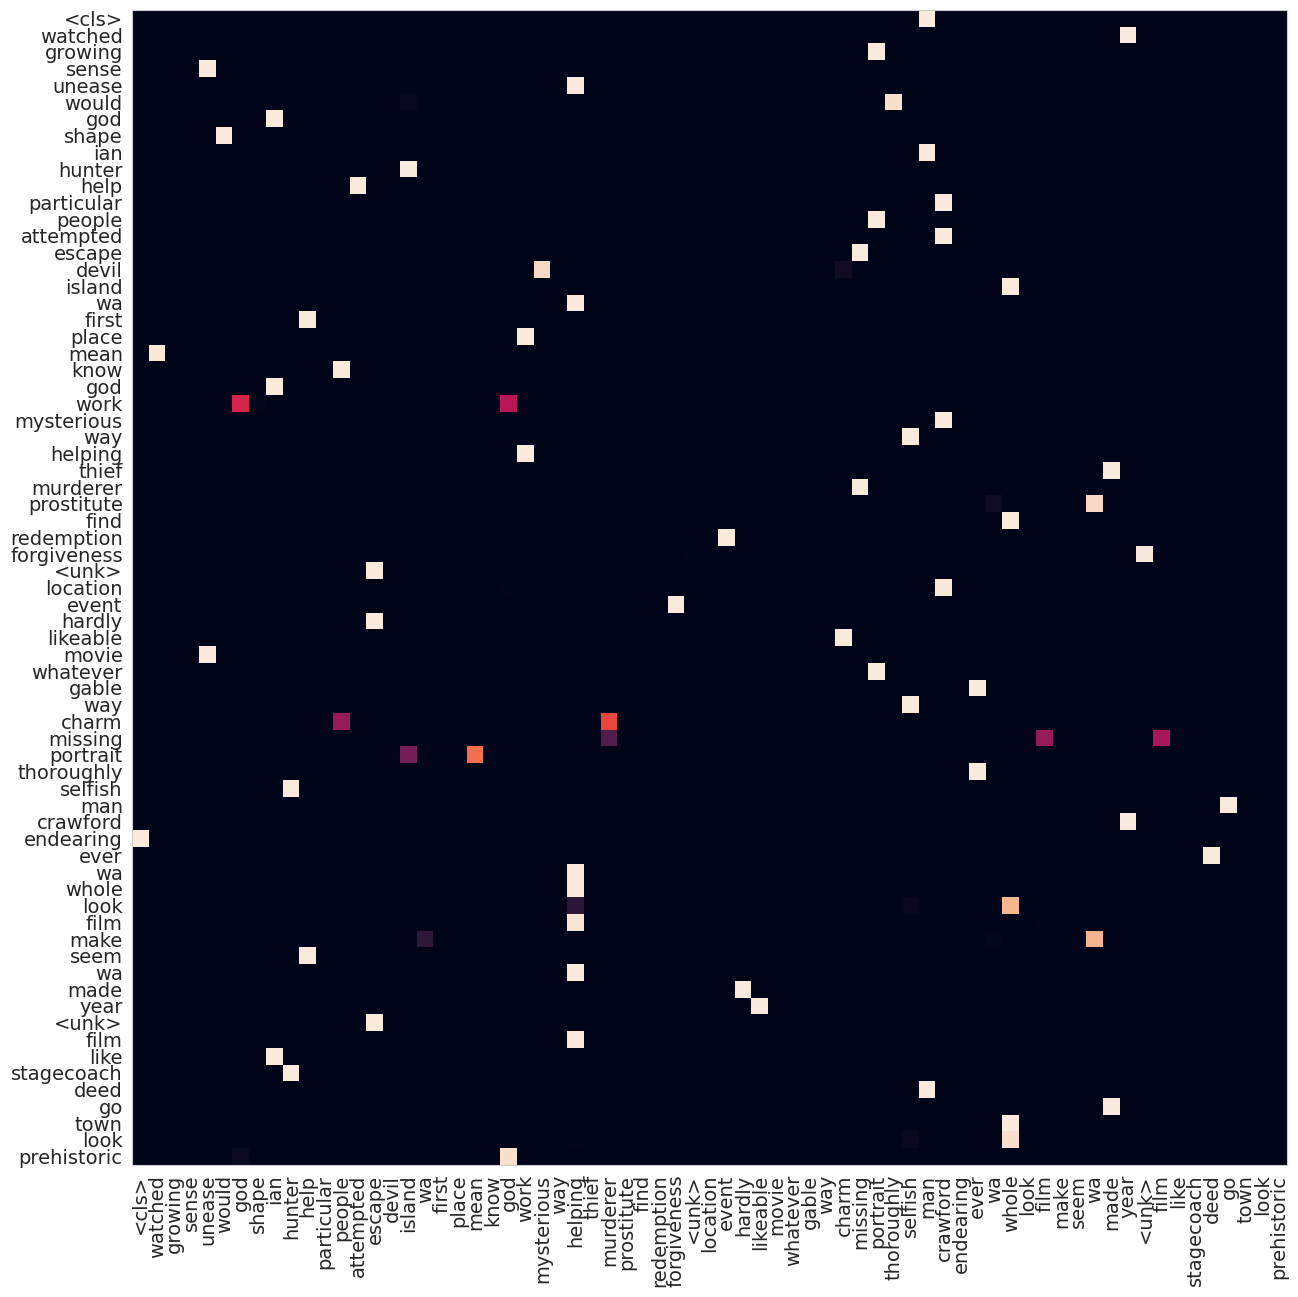

In [130]:
fig, ax = plt.subplots(figsize=(15, 15))

plt.imshow(scores[0, ..., 1, 0].cpu().numpy())
ax.set_xticks(range(len(words)))
ax.set_xticklabels(words, rotation=90)
ax.set_yticks(range(len(words)))
ax.set_yticklabels(words)

plt.grid()
plt.show()